In [1]:
from time import time

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.stats as stats
from sklearn.svm import SVC #For support vector classification (SVM)
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

In [152]:
class DenseNNDecoder(object):
    """
    Class for the dense (fully-connected) neural network decoder.

    Parameters
    ----------
    units : int or list(int)
        Number of units in each hidden layer.
        For a single hidden layer, input an integer (e.g. units=400
        will give 1 layer with 400 units).
        For multiple hidden layers, input a vector (e.g. units=[400,200])
        will give 2 layers with 400 and 200 units).

    dropout : float in range (0, 1)
        Proportion of units that get dropped out.
    
    batch_size : int
        Number of samples to process per batch.
        
    epochs : int
        Number of epochs used for training.
    
    val_prop : float in range (0, 1)
        Proportion of the training set to hold out
        for validation. If 0, no validation is done.
    
    optimizer : str
        Optimization algorithm for gradient descent.
    
    verbose : bool
        Whether to show progress of the fit after each epoch.
    """

    def __init__(self,
                 units=[256, 256],
                 dropout=0.5,
                 batch_size=30,
                 epochs=10,
                 val_prop=0.2,
                 optimizer='adam',
                 verbose=0):
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.val_prop = val_prop
        self.optimizer = optimizer
        self.verbose = verbose
        
        # Store units as a vector.
        try:
            units[0]
        except TypeError:
            units = [units]
        self.units = units
        self.num_layers = len(units) + 1

    def fit(self,
            X_train,
            y_train):
        """
        Train DenseNN Decoder.

        Parameters
        ----------
        X_train : 2D array, [n_samples, n_features]
            The neural data.
        y_train : 2D array, [n_samples, n_output_categories]
            The outputs that are being predicted.
        
        """
        start_time = time()
        
        # Check input data assumptions.
        assert X_train.shape[0] == y_train.shape[0]
        assert (self.val_prop >= 0) & (self.val_prop < 1)
        
        # Reshape data.
        n_obs = X_train.shape[0]
        self.n_feat = np.prod(X_train.shape[1:])
        if X_train.ndim > 2:
            X_train = X_train.reshape((n_obs, self.n_feat))
        if np.squeeze(y_train).ndim == 1:
            y_train = to_categorical(y_train.astype(int))
        self.n_outcat = y_train.shape[1]
        
        # Reserve a validation sample.
        if self.val_prop > 0:
            n_val = int(n_obs * self.val_prop)
            X_val = X_train[:n_val, :]
            X_train = X_train[n_val:, :]
            y_val = y_train[:n_val, :]
            y_train = y_train[n_val:, :]
            validation_data = (X_val, y_val)
        else:
            validation_data = None
        
        # Normalize the input data.
        self.X_train_mean = np.mean(X_train)
        self.X_train_std = np.std(X_train)
        X_train = (X_train - self.X_train_mean) / self.X_train_std
        X_val = (X_val - self.X_train_mean) / self.X_train_std
        
        # Build model.
        model = Sequential()
        model.add(Dense(self.units[0], activation='relu', input_shape=[self.n_feat]))
        if self.dropout != 0:
            model.add(Dropout(self.dropout))
        for iLayer in range(1, self.num_layers - 1):
            model.add(Dense(self.units[iLayer], activation='relu'))
            if self.dropout != 0:
                model.add(Dropout(self.dropout))
        model.add(Dense(y_train.shape[1], activation='softmax'))

        # Compile model.
        model.compile(optimizer=self.optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
         
        # Train model.
        model.fit(X_train, 
                  y_train,
                  batch_size=self.batch_size,
                  epochs=self.epochs,
                  validation_data=validation_data,
                  verbose=self.verbose)
        self.model = model

        if self.verbose:
            print('Done in {:.1f}s'.format(time() - start_time))
            
    def predict(self, 
                X_test):
        """
        Predict outcomes using trained DenseNN Decoder.

        Parameters
        ----------
        X_test : 2D array, [n_samples, n_features]
            The neural data being used to generate predicted outputs.

        Returns
        -------
        y_test_pred : 2D array, [n_samples, n_outputs]
            The predicted outputs.
        """
        # Reshape data.
        n_obs = X_test.shape[0]
        n_feat = np.prod(X_test.shape[1:])
        if X_test.ndim > 2:
            X_test = X_test.reshape((n_obs, n_feat))
        assert self.n_feat == n_feat
        
        # Normalize the input data.
        X_test = (X_test - self.X_train_mean) / self.X_train_std
        
        # Get predictions.
        y_test_pred_raw = self.model.predict(X_test)
        y_test_pred = np.argmax(y_test_pred_raw, axis=1)
        
        return y_test_pred
    
    def evaluate(self,
                 X_test, 
                 y_test):
        """
        Evaluate accuracy and loss.
        """
        # Reshape data.
        n_obs = X_test.shape[0]
        n_feat = np.prod(X_test.shape[1:])
        if X_test.ndim > 2:
            X_test = X_test.reshape((n_obs, n_feat))
        if np.squeeze(y_test).ndim == 1:
            y_test = to_categorical(y_test.astype(int))
        n_outcat = y_test.shape[1]
        assert self.n_feat == n_feat
        assert n_outcat == self.n_outcat
        
        # Normalize the input data.
        X_test = (X_test - self.X_train_mean) / self.X_train_std
        
        # Evaluate model performance.
        score = self.model.evaluate(X_test, 
                                    y_test, 
                                    verbose=self.verbose)
        
        return score

In [14]:
class SVClassification(object):
    """Support Vector Classification Decoder.
    
    Uses scikit-learn SVM.
    
    Parameters
    ----------
    C : float, default=3.0
        Penalty parameter of the error term.
    kernel : str, default='rbf'
        Specifies the type of kernel to be used in the algorithm.
        It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’,
        or a callable.
    max_iter : int, default=-1
        The maximum number of iteraations to run; max_iter=-1 means no limit.
        Typically in the 1000s takes a short amount of time on a laptop.
    """
    def __init__(self,
                 C=3.0,
                 kernel='rbf',
                 max_iter=-1,
                 verbose=False):
        self.C = C
        self.kernel = kernel
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self,
            X_train,
            y_train):
        """
        Train SVM classifier.

        Parameters
        ----------
        X_train : 2D array, [n_samples, n_features]
            The neural data.
        y_test_pred : 1D array, [n_samples,]
            The outputs that are being predicted.
        """
        start_time = time()
        
        # Check input data assumptions.
        assert X_train.shape[0] == y_train.shape[0]
        
        # Reshape data.
        n_obs = X_train.shape[0]
        self.n_feat = np.prod(X_train.shape[1:])
        if X_train.ndim > 2:
            X_train = X_train.reshape((n_obs, self.n_feat))
        self.n_outcat = np.unique(y_train).size
        y_train = np.squeeze(y_train)
        assert y_train.ndim == 1
        
        # Normalize the input data.
        self.X_train_mean = np.mean(X_train)
        self.X_train_std = np.std(X_train)
        X_train = (X_train - self.X_train_mean) / self.X_train_std
        
        # Build model.
        model = SVC(C=self.C,
                    kernel=self.kernel,
                    max_iter=self.max_iter,
                    verbose=self.verbose)
        
        # Train model.
        model.fit(X_train, y_train)
        self.model = model
        
        if self.verbose:
            print('Done in {:.1f}s'.format(time() - start_time))

    def predict(self,
                X_test):
        """Predict outcomes using trained SVM classifier.

        Parameters
        ----------
        X_test : 2D array, [n_samples, n_features]
            The neural data being used to generate predicted outputs.

        Returns
        -------
        y_test_pred : 1D array, [n_samples,]
            The predicted outputs.
        """
        # Reshape data.
        n_obs = X_test.shape[0]
        n_feat = np.prod(X_test.shape[1:])
        assert self.n_feat == n_feat
        if X_test.ndim > 2:
            X_test = X_test.reshape((n_obs, n_feat))
        
        # Normalize the input data.
        X_test = (X_test - self.X_train_mean) / self.X_train_std
        
        # Get predictions.
        model = self.model
        y_test_pred = model.predict(X_test)
        
        return y_test_pred
    
    def score(self,
              X_test, 
              y_test):
        """
        Return the mean accuracy for observations in X_test.
        
        Parameters
        ----------
        X_test : 2D array, [n_samples, n_features]
            The neural data being used to generate predicted outputs.
        y_test : 1D array, [n_samples,]
            The correct outputs labels.
        """
        # Reshape data.
        n_obs = X_test.shape[0]
        n_feat = np.prod(X_test.shape[1:])
        assert self.n_feat == n_feat
        if X_test.ndim > 2:
            X_test = X_test.reshape((n_obs, n_feat))
        y_test = np.squeeze(y_test)
        assert y_test.ndim == 1
        
        # Normalize the input data.
        X_test = (X_test - self.X_train_mean) / self.X_train_std
        
        # Evaluate model performance.
        score = self.model.score(X_test, 
                                 y_test)
        
        return score

# Load data

In [5]:
from keras.datasets import mnist

In [6]:
n_obs = 360
test_prop = 1/6

# Load data.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Select a subset of the data.
train_obs = int(n_obs*(1-test_prop))
test_obs = int(n_obs*test_prop)
X_train = X_train[:train_obs, :]
X_test = X_test[:test_obs, :]
if np.squeeze(y_train).ndim == 1:
    y_train = y_train[:train_obs]
    y_test = y_test[:test_obs]
else:
    y_train = y_train[:train_obs, :]
    y_test = y_test[:test_obs, :]
    
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(300, 28, 28) (300,) (60, 28, 28) (60,)


# Cross-validation setup

In [46]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split

In [49]:
# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

X_iris.shape, y_iris.shape

((150, 4), (150,))

In [52]:
inner_cv.get_n_splits()

4

Average difference of 0.009590 with std. dev. of 0.008692.


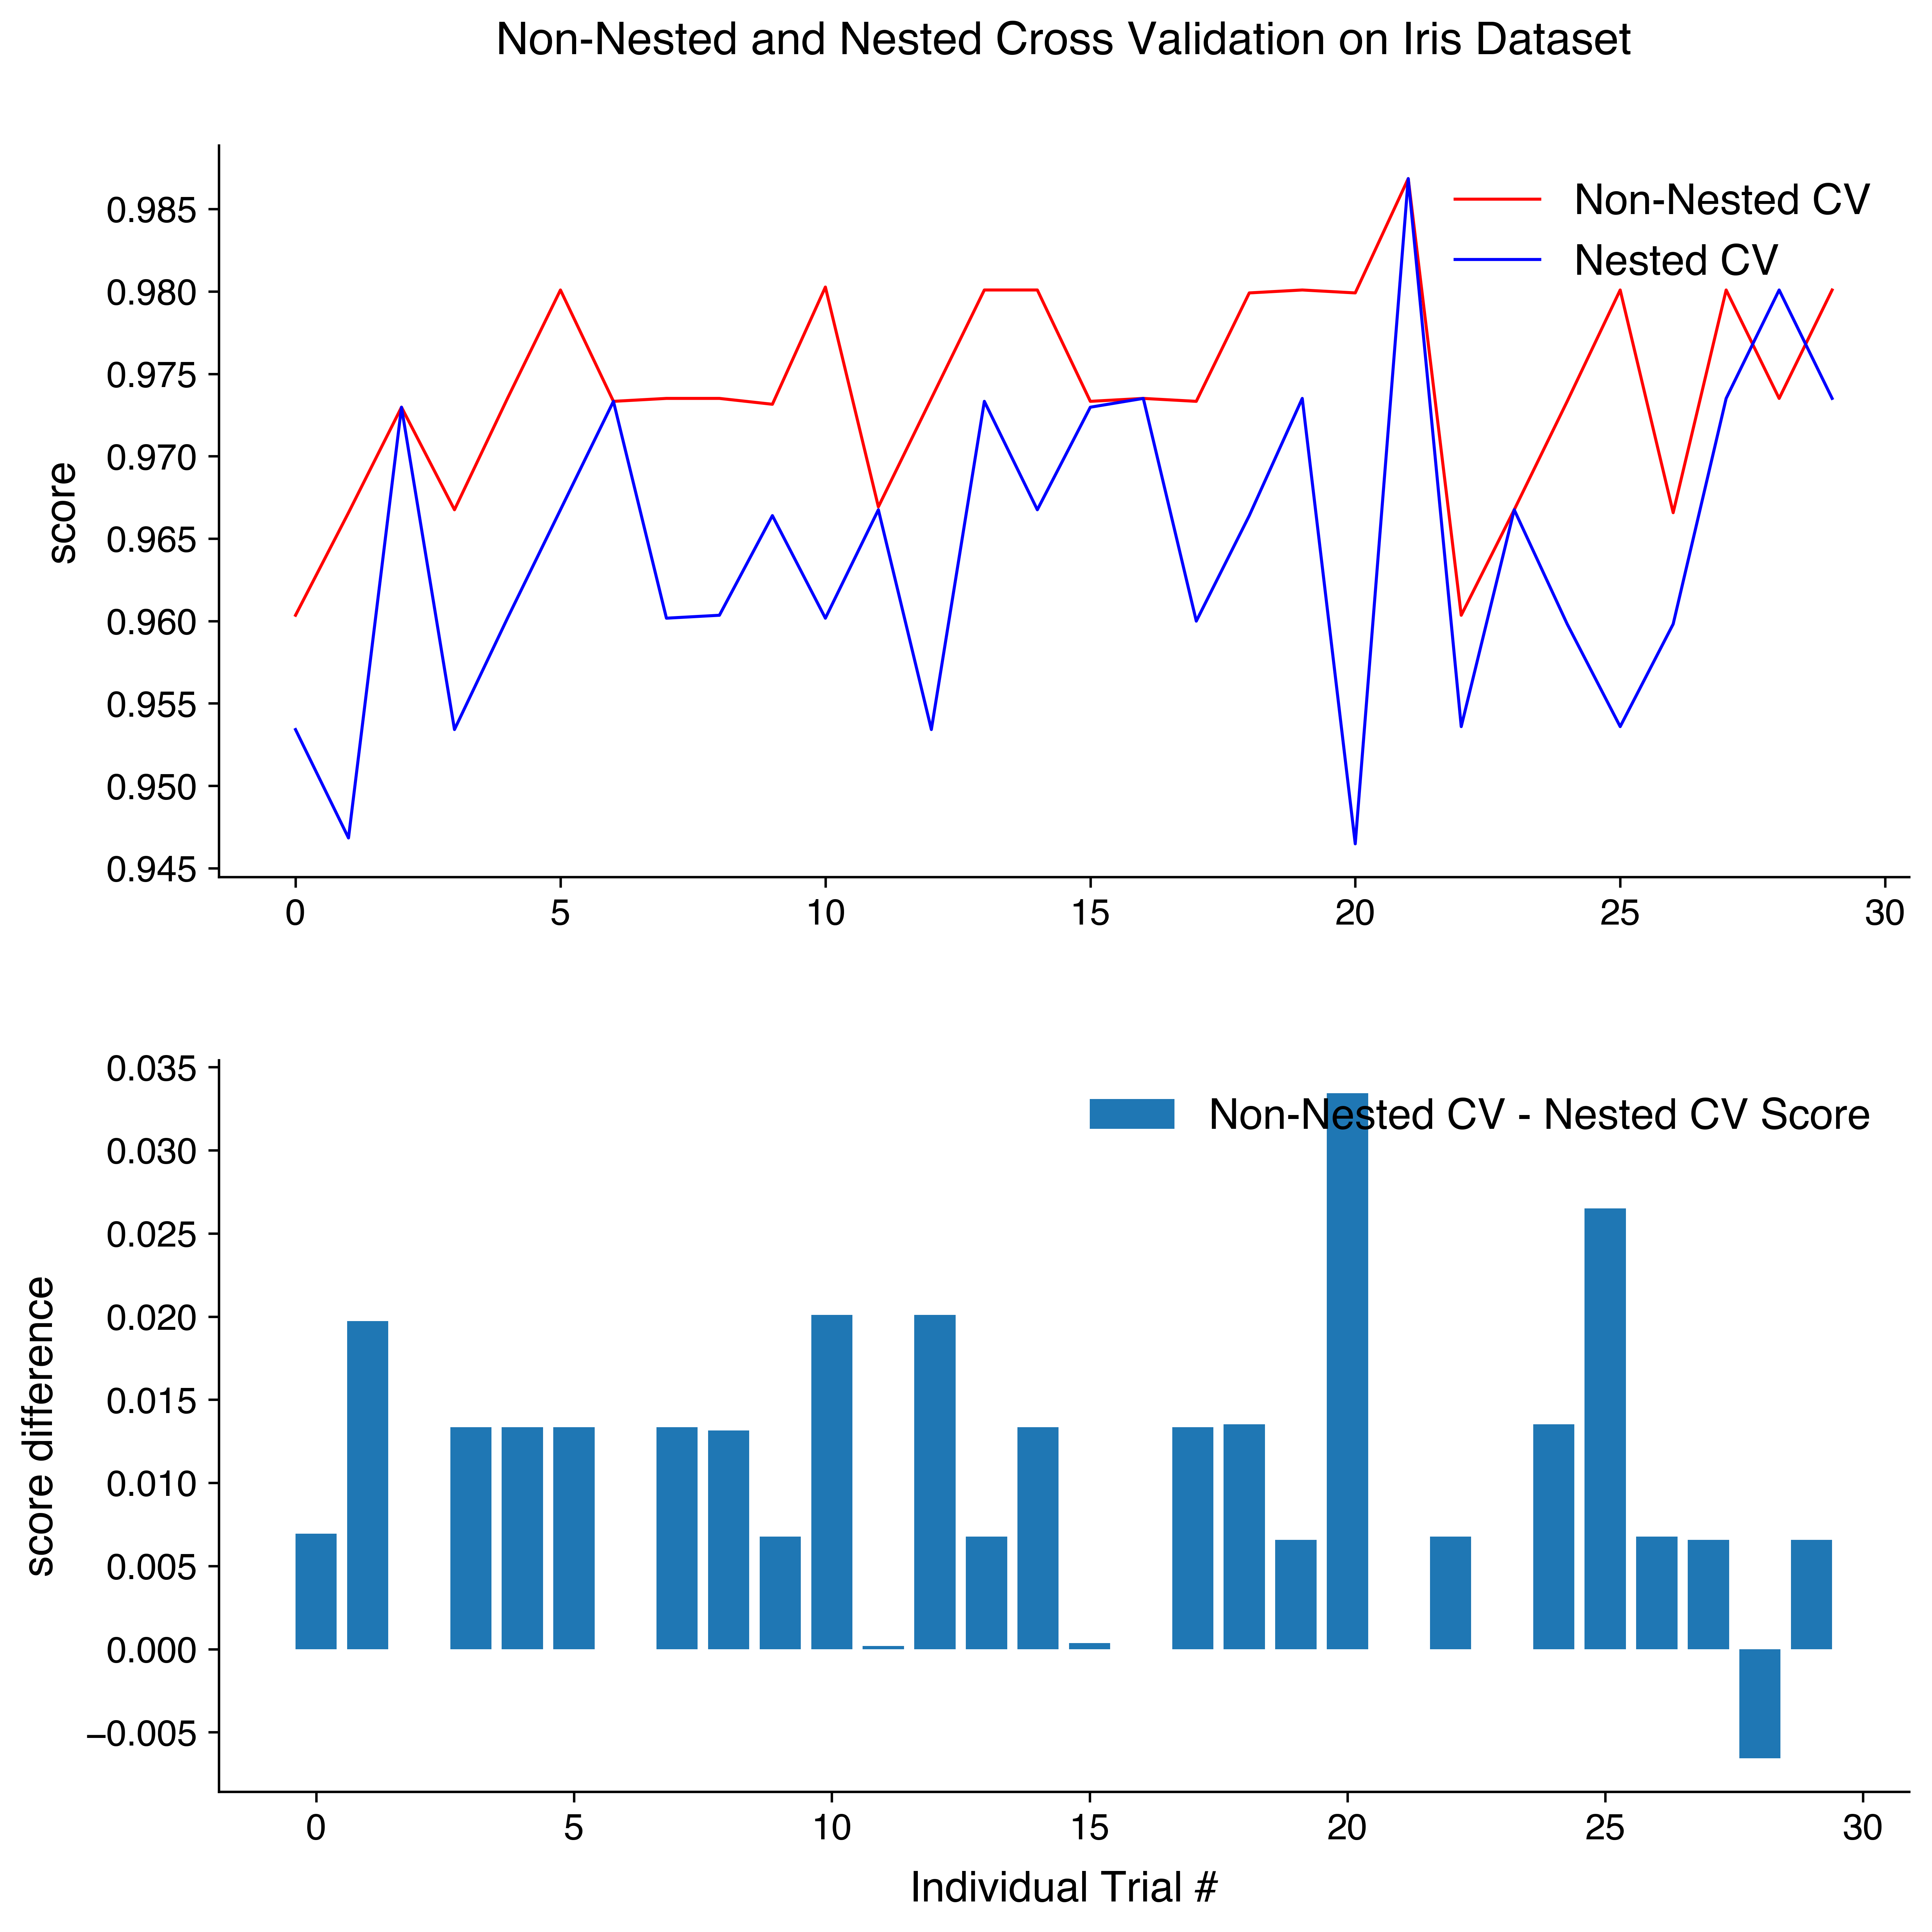

In [31]:
# Number of random trials
NUM_TRIALS = 30

# Set up possible values of parameters to optimize over
p_grid = {'C'     : np.logspace(-3, 3, 7),
          'gamma' : np.logspace(-3, 3, 7)}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.close()
plt.figure(figsize=(10, 10), dpi=600)
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"], loc=1)
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"], loc=1)
plt.ylabel("score difference", fontsize="14")

plt.show()

In [45]:
clf.best_estimator_, clf.best_index_, clf.best_params_, clf.best_score_

(SVC(C=10.0, gamma=0.1), 30, {'C': 10.0, 'gamma': 0.1}, 0.9800853485064012)

# LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# SVM

In [15]:
# Declare model.
C = 3.0
verbose = True
svc = SVClassification(C=C, verbose=verbose)

# Fit model.
svc.fit(X_train, y_train)

# Generate predictions.
y_test_pred = svc.predict(X_test)

# Evaluate the fit.
results = svc.score(X_test, y_test)

# Compare to a shuffled test vector.
shuf_idx = np.arange(y_test.shape[0])
np.random.shuffle(shuf_idx)
_ = svc.score(X_test, y_test[shuf_idx])

[LibSVM]Done in 0.2s


In [54]:
model = SVC()

In [56]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [19]:
svc.n_feat, svc.n_outcat

(784, 10)

In [16]:
_

0.11666666666666667

In [17]:
results

0.8333333333333334

# Neural net

In [162]:
# Declare model.
nn = DenseNNDecoder(units=[256, 256],
                    dropout=0.5,
                    batch_size=30,
                    epochs=20,
                    val_prop=0.2,
                    verbose=1)

# Fit model.
nn.fit(X_train, y_train)

# Generate predictions.
y_test_pred = nn.predict(X_test)

# Evaluate the fit.
results = nn.evaluate(X_test, y_test)

# Compare to a shuffled test vector.
shuf_idx = np.arange(y_test.shape[0])
np.random.shuffle(shuf_idx)
_ = nn.evaluate(X_test, y_test[shuf_idx])

Epoch 1/20
8/8 [==============================] - 0s 48ms/step - loss: 2.7352 - accuracy: 0.1542 - val_loss: 29.4918 - val_accuracy: 0.4333
Epoch 2/20
8/8 [==============================] - 0s 15ms/step - loss: 1.7646 - accuracy: 0.3875 - val_loss: 26.8060 - val_accuracy: 0.5667
Epoch 3/20
8/8 [==============================] - 0s 12ms/step - loss: 1.3153 - accuracy: 0.5792 - val_loss: 26.8163 - val_accuracy: 0.6333
Epoch 4/20
8/8 [==============================] - 0s 20ms/step - loss: 1.0231 - accuracy: 0.6917 - val_loss: 31.8053 - val_accuracy: 0.6500
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 0.7808 - accuracy: 0.7333 - val_loss: 37.7692 - val_accuracy: 0.6500
Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 0.6203 - accuracy: 0.7958 - val_loss: 34.3743 - val_accuracy: 0.7000
Epoch 7/20
8/8 [==============================] - 0s 23ms/step - loss: 0.5871 - accuracy: 0.7958 - val_loss: 41.4311 - val_accuracy: 0.7167
Epoch 8/20
8/8 [====

In [163]:
nn.model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 256)               200960    
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [171]:
np.sum(y_test_pred == np.argmax(to_categorical(y_test.astype(int)), axis=1)) / X_test.shape[0]

0.8666666666666667

In [129]:
"""Build and train neural network"""

NUM_ROWS = 28
NUM_COLS = 28
NUM_CLASSES = 10
UNITS = 1012#256
BATCH_SIZE = 30
EPOCHS = 20

DROPOUT = 0.5

N_TRAIN = 240
N_VAL = 60
N_TEST = 60
"""Load and prepare data"""

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data
X_train = X_train.reshape((X_train.shape[0], np.prod([X_train.shape[1:]])))
X_test = X_test.reshape((X_test.shape[0], np.prod([X_train.shape[1:]])))
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Reserve a validation sample
X_val = X_train[:N_VAL, :]
X_train = X_train[N_VAL:N_VAL+N_TRAIN, :]
y_val = y_train[:N_VAL, :]
y_train = y_train[N_VAL:N_VAL+N_TRAIN, :]
X_test = X_test[:N_TEST, :]
y_test = y_test[:N_TEST, :]

# Normalize input data.
#X_train = X_train.astype('float32') / 255 # normalize pixel intensity between 0 and 1
#X_test = X_test.astype('float32') / 255 # normalize pixel intensity between 0 and 1
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# Build neural network
model = Sequential()
model.add(Dense(UNITS, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(DROPOUT))
model.add(Dense(UNITS, activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1, 
          validation_data=(X_val, y_val))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

shuf_idx = np.arange(y_test.shape[0])
np.random.shuffle(shuf_idx)
score = model.evaluate(X_test, y_test[shuf_idx], verbose=0)
print('Shuf. test loss:', score[0])
print('Shuf. test accuracy:', score[1])

"""Summarize and visualize the model"""

# Summary of neural network
model.summary()

Epoch 1/20
8/8 [==============================] - 0s 47ms/step - loss: 3.0712 - accuracy: 0.3542 - val_loss: 0.9145 - val_accuracy: 0.6833
Epoch 2/20
8/8 [==============================] - 0s 16ms/step - loss: 0.7148 - accuracy: 0.7542 - val_loss: 0.7131 - val_accuracy: 0.7667
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 0.5534 - accuracy: 0.8417 - val_loss: 0.5868 - val_accuracy: 0.8167
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 0.2668 - accuracy: 0.9333 - val_loss: 0.6929 - val_accuracy: 0.7833
Epoch 5/20
8/8 [==============================] - 0s 44ms/step - loss: 0.3247 - accuracy: 0.8875 - val_loss: 0.7571 - val_accuracy: 0.7333
Epoch 6/20
8/8 [==============================] - 0s 23ms/step - loss: 0.3054 - accuracy: 0.8958 - val_loss: 0.6315 - val_accuracy: 0.8000
Epoch 7/20
8/8 [==============================] - 0s 27ms/step - loss: 0.2207 - accuracy: 0.9292 - val_loss: 0.8316 - val_accuracy: 0.7500
Epoch 8/20
8/8 [===========